# Group 6 Internal Project

 This project is a real estate price predictor which involves GenAI, it's meant to help prospective buyers determine whether they are getting a "good deal"  on a house based on if it's listed price is above or below the price our model predicts for it.

## Exploratory Data Analysis

In [ ]:
!pip3 install pandas
!pip3 install numpy
!pip3 install seaborn
!pip3 install scikit-learn
!pip2 install matplotlib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv("usa_real_estate.csv")

# 1. Quick overview
print("Shape:", df.shape)
print("\nColumn types:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isna().sum())

print("\nSummary statistics for numeric columns:")
print(df.describe().T)

In [2]:
# 2. Unique values / basic checks for categoricals
print("\nStatus value counts:")
print(df['status'].value_counts(dropna=False).head(20))

print("\nTop 20 cities:")
print(df['city'].value_counts().head(20))

print("\nStates:")
print(df['state'].value_counts())


Status value counts:
status
for_sale          1031598
ready_to_build      16977
Name: count, dtype: int64

Top 20 cities:
city
Chicago           12688
New York City      8248
Philadelphia       8206
Miami              6128
Jacksonville       5873
New York           5297
Brooklyn           5123
Naples             4630
Port Charlotte     4299
Cape Coral         4163
Lehigh Acres       4077
Washington         3883
Atlanta            3786
Baltimore          3466
Ocala              3124
Orlando            3080
Dallas             3057
Columbus           2806
Louisville         2743
Tampa              2658
Name: count, dtype: int64

States:
state
Florida                 163840
New York                 71399
North Carolina           58283
Illinois                 53432
Georgia                  52030
Pennsylvania             48885
Texas                    40111
Ohio                     37972
Tennessee                36650
Michigan                 36336
Virginia                 36087
New Jersey

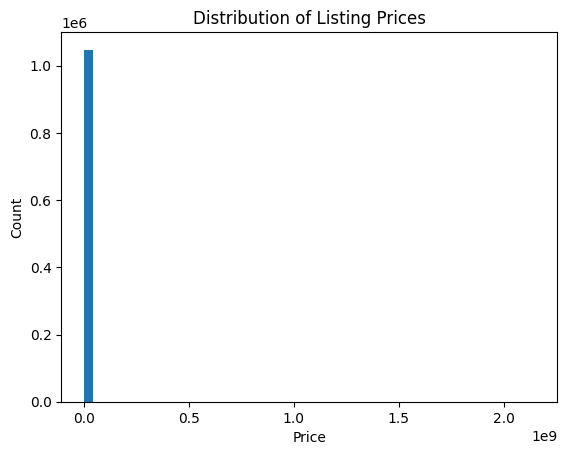

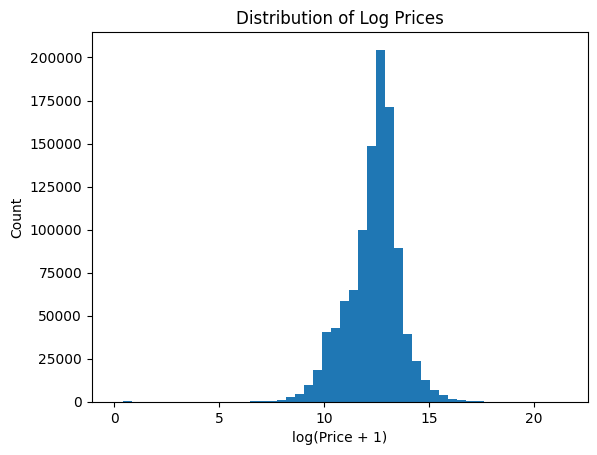

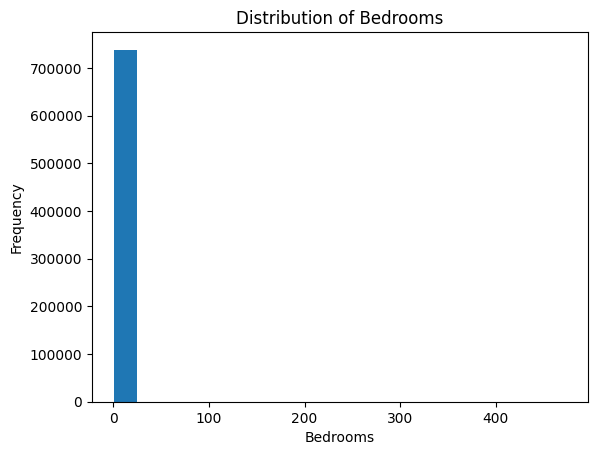

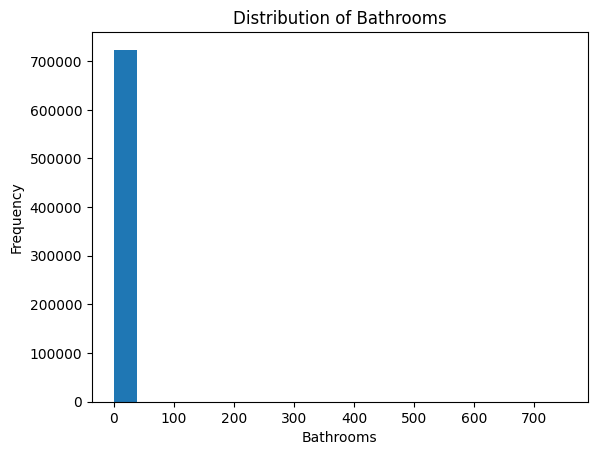

In [3]:
# 3. Simple distributions

# Price distribution (use log to handle skew) (as housing prices are skweded, many cheap houses, few extremely expensive ones)
df['log_price'] = df['price'].apply(lambda x: np.log1p(x) if pd.notna(x) else x)

plt.figure()
df['price'].dropna().plot(kind='hist', bins=50)
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of Listing Prices")
plt.show()

plt.figure()
df['log_price'].dropna().plot(kind='hist', bins=50)
plt.xlabel("log(Price + 1)")
plt.ylabel("Count")
plt.title("Distribution of Log Prices")
plt.show()

# Beds and baths
plt.figure()
df['bed'].dropna().plot(kind='hist', bins=20)
plt.xlabel("Bedrooms")
plt.title("Distribution of Bedrooms")
plt.show()

plt.figure()
df['bath'].dropna().plot(kind='hist', bins=20)
plt.xlabel("Bathrooms")
plt.title("Distribution of Bathrooms")
plt.show()

### Price vs House Size (Scatter Plot)

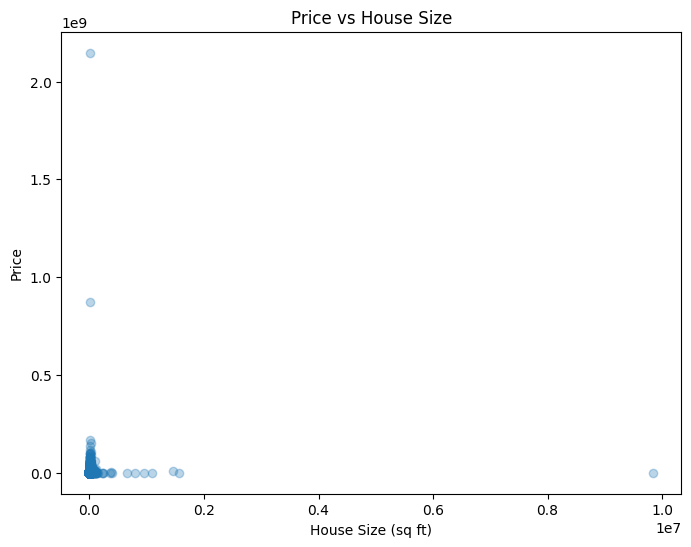

In [4]:
# Remove rows where house_size or price is missing
df_clean = df[['price', 'house_size']].dropna()

# Make a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(df_clean['house_size'], df_clean['price'], alpha=0.3)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size")
plt.show()

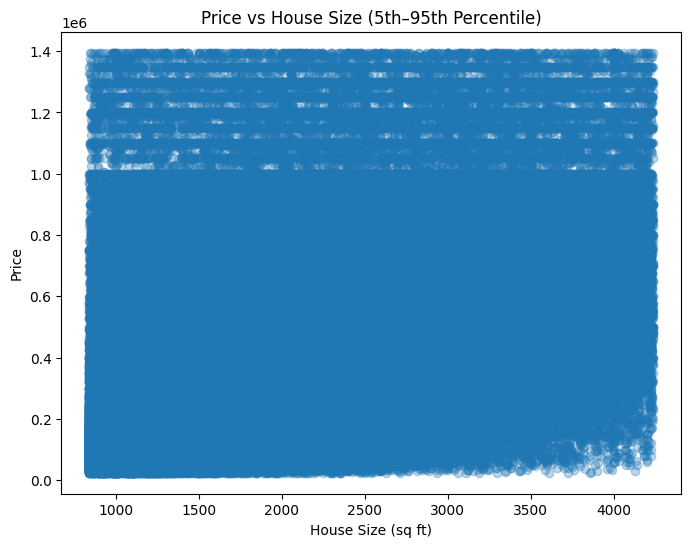

In [5]:
# Filter to remove extreme outliers
p_low = df['house_size'].quantile(0.05)
p_high = df['house_size'].quantile(0.95)

df_filtered = df[(df['house_size'] >= p_low) & (df['house_size'] <= p_high)]

# Filter price too
pr_low = df['price'].quantile(0.05)
pr_high = df['price'].quantile(0.95)

df_filtered = df_filtered[(df_filtered['price'] >= pr_low) & (df_filtered['price'] <= pr_high)]

plt.figure(figsize=(8,6))
plt.scatter(df_filtered['house_size'], df_filtered['price'], alpha=0.3)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size (5th–95th Percentile)")
plt.show()


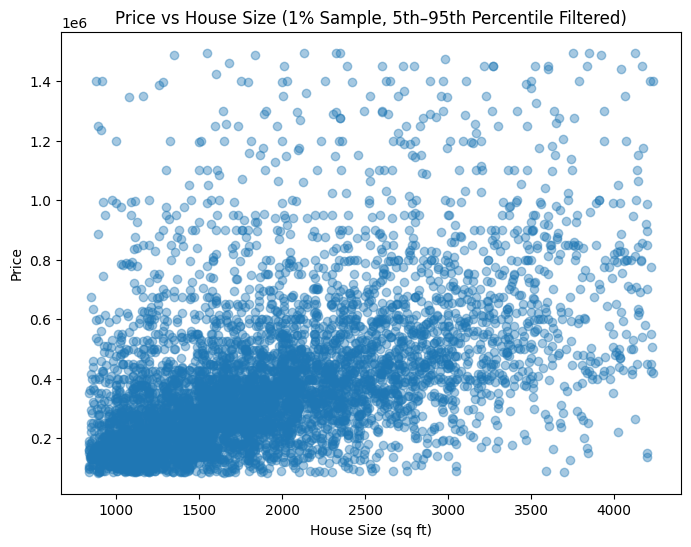

In [6]:
# Apply 5th–95th percentile filtering first
p_low_size = df_clean['house_size'].quantile(0.05)
p_high_size = df_clean['house_size'].quantile(0.95)

p_low_price = df_clean['price'].quantile(0.05)
p_high_price = df_clean['price'].quantile(0.95)

df_filtered = df_clean[
    (df_clean['house_size'] >= p_low_size) &
    (df_clean['house_size'] <= p_high_size) &
    (df_clean['price'] >= p_low_price) &
    (df_clean['price'] <= p_high_price)
]

# Take a 1% random sample
df_sample = df_filtered.sample(frac=0.01, random_state=42)

# Plot sampled scatterplot
plt.figure(figsize=(8, 6))
plt.scatter(df_sample['house_size'], df_sample['price'], alpha=0.4)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Price vs House Size (1% Sample, 5th–95th Percentile Filtered)")
plt.show()\

# Price does increase as house size increases
# Most homes fall between:
# 1,000–4,000 sq ft
# $150k – $600k
# The relationship is positive but noisy → size matters, but not the only factor (location, quality, etc.)

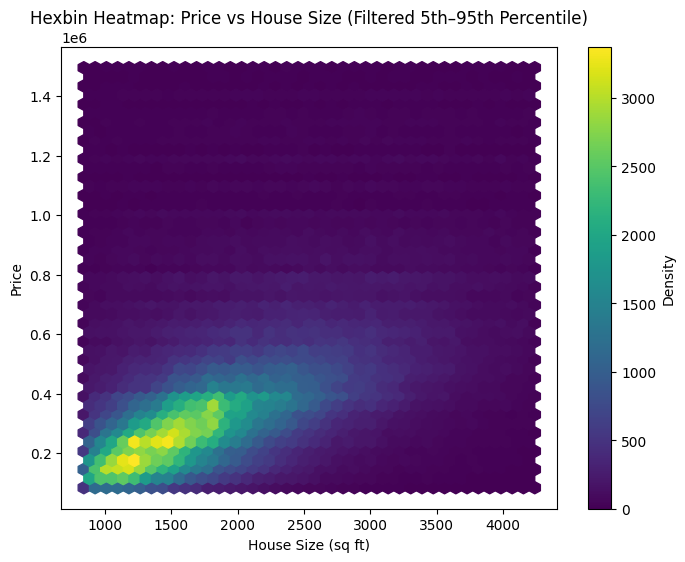

In [7]:
# Hexbin plot
plt.figure(figsize=(8, 6))
plt.hexbin(df_filtered['house_size'], df_filtered['price'], gridsize=40)
plt.xlabel("House Size (sq ft)")
plt.ylabel("Price")
plt.title("Hexbin Heatmap: Price vs House Size (Filtered 5th–95th Percentile)")
plt.colorbar(label="Density")
plt.show()

# The bright yellow/green cluster shows that most homes are around: 1,200–2,000 sq ft & $150,000–$350,000
# The hexbin shape slopes upward, which shows, As house size increases → price increases

state
District of Columbia    700000.0
Massachusetts           585000.0
Montana                 475000.0
Idaho                   454500.0
New Hampshire           439000.0
Delaware                409900.0
New York                399999.0
Virginia                399900.0
Virgin Islands          399000.0
Florida                 395900.0
Name: price, dtype: float64


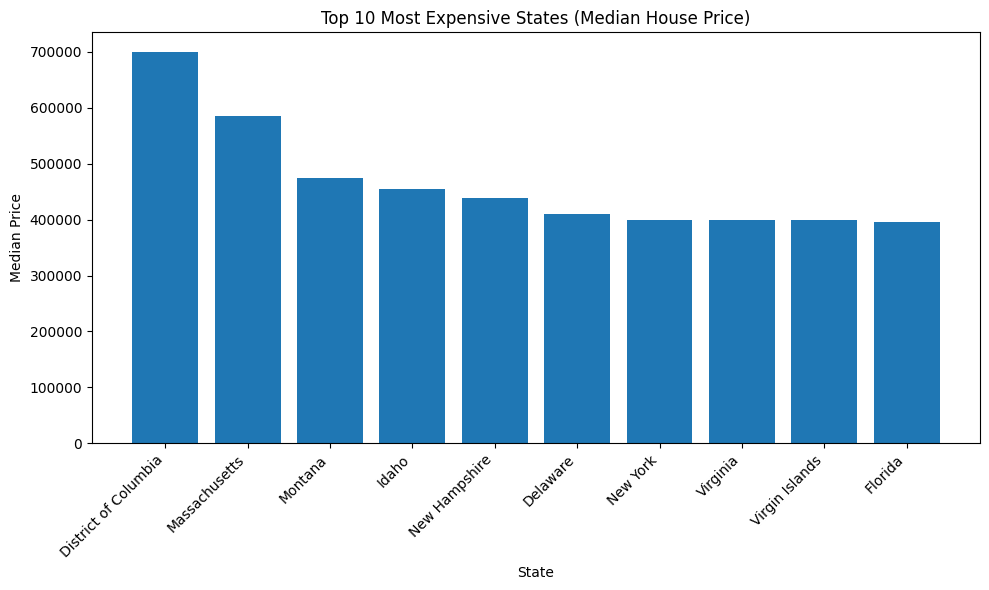

In [8]:
df_state = df[['state', 'price', 'house_size']].dropna()

#    for BOTH price and house_size – this is what keeps CA sane
p_low  = df_state['price'].quantile(0.05)
p_high = df_state['price'].quantile(0.95)
s_low  = df_state['house_size'].quantile(0.05)
s_high = df_state['house_size'].quantile(0.95)

df_state_filtered = df_state[
    (df_state['price'].between(p_low, p_high)) &
    (df_state['house_size'].between(s_low, s_high))
]

state_prices = (
    df_state_filtered
    .groupby('state')['price']
    .median()
    .sort_values(ascending=False)
)

top10 = state_prices.head(10)
print(top10)

# 6. Plot – this should look like your first screenshot
plt.figure(figsize=(10, 6))
plt.bar(top10.index, top10.values)
plt.xlabel("State")
plt.ylabel("Median Price")
plt.title("Top 10 Most Expensive States (Median House Price)")
plt.xticks(rotation=45, ha="right")
plt.ticklabel_format(style='plain', axis='y')  # remove 1e6 scientific notation
plt.tight_layout()
plt.show()

In [9]:
!pip install plotly
!pip install ipython nbformat>=4.2.0
import plotly.express as px
from IPython.display import HTML

# State name → abbreviation map
state_map = {
    'Alabama':'AL','Alaska':'AK','Arizona':'AZ','Arkansas':'AR','California':'CA',
    'Colorado':'CO','Connecticut':'CT','Delaware':'DE','District of Columbia':'DC',
    'Florida':'FL','Georgia':'GA','Hawaii':'HI','Idaho':'ID','Illinois':'IL',
    'Indiana':'IN','Iowa':'IA','Kansas':'KS','Kentucky':'KY','Louisiana':'LA',
    'Maine':'ME','Maryland':'MD','Massachusetts':'MA','Michigan':'MI','Minnesota':'MN',
    'Mississippi':'MS','Missouri':'MO','Montana':'MT','Nebraska':'NE','Nevada':'NV',
    'New Hampshire':'NH','New Jersey':'NJ','New Mexico':'NM','New York':'NY',
    'North Carolina':'NC','North Dakota':'ND','Ohio':'OH','Oklahoma':'OK',
    'Oregon':'OR','Pennsylvania':'PA','Rhode Island':'RI','South Carolina':'SC',
    'South Dakota':'SD','Tennessee':'TN','Texas':'TX','Utah':'UT','Vermont':'VT',
    'Virginia':'VA','Washington':'WA','West Virginia':'WV','Wisconsin':'WI','Wyoming':'WY',
    'Puerto Rico':'PR','Virgin Islands':'VI'
}

df['state_code'] = df['state'].map(state_map)

# Drop rows with unmapped states
df = df.dropna(subset=['state_code'])

# Keep needed columns
df_state = df[['state_code', 'price', 'house_size']].dropna()

# Percentile filtering
p_low_size = df_state['house_size'].quantile(0.05)
p_high_size = df_state['house_size'].quantile(0.95)
p_low_price = df_state['price'].quantile(0.05)
p_high_price = df_state['price'].quantile(0.95)

df_state_filtered = df_state[
    (df_state['house_size'] >= p_low_size) &
    (df_state['house_size'] <= p_high_size) &
    (df_state['price'] >= p_low_price) &
    (df_state['price'] <= p_high_price)
]

# Median price by state
state_prices = df_state_filtered.groupby('state_code')['price'].median().reset_index()

# Choropleth using state_code
fig = px.choropleth(
    state_prices,
    locations="state_code",
    locationmode="USA-states",
    color="price",
    color_continuous_scale="Viridis",
    scope="usa",
    labels={'price':'Median Price'},
    title="Median House Price by State (Choropleth Map)"
)

fig.show()

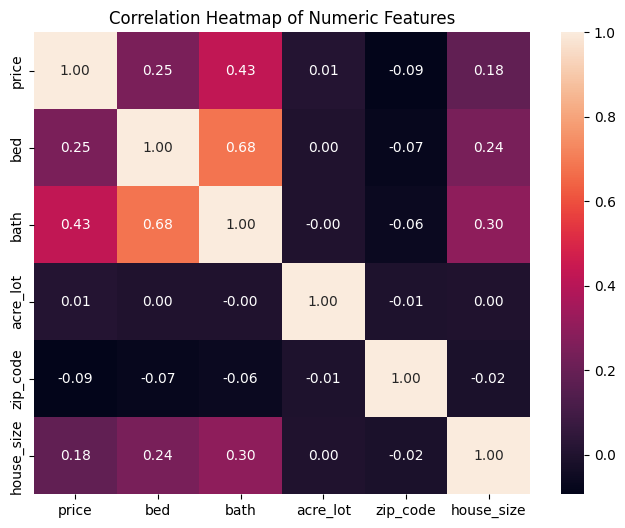

In [10]:
import seaborn as sns

# Select numeric columns only
numeric_df = df[['price', 'bed', 'bath', 'acre_lot', 'zip_code', 'house_size']].dropna()

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


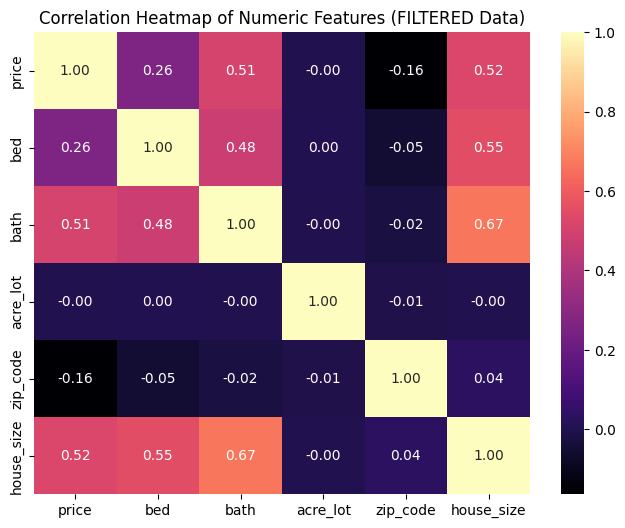

In [11]:
df_mod = df[['price', 'bed', 'bath', 'house_size', 'acre_lot', 'zip_code']].dropna()

# Apply 5th–95th percentile filtering
for col in ['price', 'house_size']:
    low = df_mod[col].quantile(0.05)
    high = df_mod[col].quantile(0.95)
    df_mod = df_mod[(df_mod[col] >= low) & (df_mod[col] <= high)]

# Step 3: Create numeric-only dataset
numeric_df = df_mod[['price', 'bed', 'bath', 'acre_lot', 'zip_code', 'house_size']]

# Step 4: Compute correlation matrix
corr_matrix = numeric_df.corr()

# Step 5: Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="magma")
plt.title("Correlation Heatmap of Numeric Features (FILTERED Data)")
plt.show()


In [12]:
df_sub = df[['price', 'state', 'city']].dropna()

# Apply percentile filtering on price to remove extreme outliers
p_low  = df_sub['price'].quantile(0.05)
p_high = df_sub['price'].quantile(0.95)

df_sub = df_sub[(df_sub['price'] >= p_low) & (df_sub['price'] <= p_high)]

# --- Correlation Ratio Function (η²) ---
def correlation_ratio(categories, measurements):
    categories = pd.Categorical(categories)
    cat_codes = categories.codes
    grand_mean = np.mean(measurements)
    ss_between = 0
    for cat in np.unique(cat_codes):
        group = measurements[cat_codes == cat]
        ss_between += len(group) * (np.mean(group) - grand_mean)**2
    ss_total = np.sum((measurements - grand_mean)**2)
    return ss_between / ss_total if ss_total != 0 else 0

# Compute correlation ratios
eta_state = correlation_ratio(df_sub['state'], df_sub['price'])
eta_city = correlation_ratio(df_sub['city'], df_sub['price'])

eta_state, eta_city



(np.float64(0.06975369590776247), np.float64(0.27900389069043324))

## Feature Engineering

This section prepares some of the columns and datatypes of the data for training our price prediction model.

In [ ]:
# Removing street, zip code, broker-id, status and prev sold date columns as they are not relevant to the model and may reduce accuracy in price prediction.
new_df = df.drop(['brokered_by', 'status', 'street', 'zip_code', 'prev_sold_date', 'log_price', 'state_code'], axis = 1)
new_df

In [ ]:
# Changing acre_lot to square foot as zillow lists the area in square foot, as well as changing the name  of the column to lot_size for clarity
new_df = new_df.rename(columns={'acre_lot' : 'lot_size'})
new_df['lot_size'] = new_df['lot_size'] * 43560
new_df

In [15]:
# Dropping null values
new_df = new_df.dropna()
new_df.describe()

,price,bed,bath,lot_size,house_size
count,5.265140e+05,526514.000000,526514.000000,5.265140e+05,5.265140e+05
mean,5.219685e+05,3.450159,2.588510,5.936669e+05,2.205162e+03
std,3.175880e+06,1.349853,1.396186,3.645592e+07,3.580245e+03
min,0.000000e+00,1.000000,1.000000,0.000000e+00,1.000000e+02
25%,2.000000e+05,3.000000,2.000000,6.534000e+03,1.388000e+03
50%,3.311060e+05,3.000000,2.000000,1.089000e+04,1.863000e+03
75%,5.250000e+05,4.000000,3.000000,2.657160e+04,2.587000e+03
max,2.147484e+09,190.000000,198.000000,4.356000e+09,1.560780e+06


In [16]:
# Label encoding city and state columns
from sklearn.preprocessing import LabelEncoder

le_state = LabelEncoder()
new_df['state'] = le_state.fit_transform(new_df['state'])

le_city = LabelEncoder()
new_df['city'] = le_city.fit_transform(new_df['city'])
new_df.head()

/tmp/ipykernel_10956/547994110.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_10956/547994110.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,price,bed,bath,lot_size,city,state,house_size
0,105000.0,3.0,2.0,5227.2,52,34,920.0
1,80000.0,4.0,2.0,3484.8,52,34,1527.0
2,67000.0,2.0,1.0,6534.0,6001,34,748.0
3,145000.0,4.0,2.0,4356.0,9721,34,1800.0
5,179000.0,4.0,3.0,20037.6,10733,34,2520.0


In [17]:
# After dropping null values some of the states and cities are no longer in our dataset
print(f'no. of states left in the dataset post dropping null values: {max(new_df['state'].unique())}')
print(f'no. of cities left in the dataset post dropping null values: {max(new_df['city'].unique())}')

no. of states left in the dataset post dropping null values: 45
no. of cities left in the dataset post dropping null values: 13525


In [18]:
new_df.info

<bound method DataFrame.info of             price  bed  bath  lot_size   city  state  house_size
0        105000.0  3.0   2.0    5227.2     52     34       920.0
1         80000.0  4.0   2.0    3484.8     52     34      1527.0
2         67000.0  2.0   1.0    6534.0   6001     34       748.0
3        145000.0  4.0   2.0    4356.0   9721     34      1800.0
5        179000.0  4.0   3.0   20037.6  10733     34      2520.0
...           ...  ...   ...       ...    ...    ...         ...
1048568  508620.0  4.0   3.0   16988.4   5117     39      2595.0
1048569  523171.0  4.0   3.0   17424.0   5117     39      2629.0
1048570  467847.0  5.0   4.0    8276.4   5117     39      3499.0
1048571  345249.0  5.0   3.0    8276.4   5117     39      2572.0
1048573  456122.0  5.0   4.0    8276.4   5117     39      3499.0

[526514 rows x 7 columns]>

## Model Selection & Training

In this section we test three models (Random Forrest, Gradient Boost and XGBoost) for accuracy and train our dataset on the most accurate one.

In [19]:
# Importing relevant libraries and funcions
!pip install xgboost
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import train_test_split

# Splitting data into test and split
# Features
X = new_df[['house_size', 'bed', 'bath', 'city', 'state', 'lot_size']]

# Target
y = new_df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameters tuning
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state = 42, eval_metric='logloss')
}

param_grid = {
    'RandomForest': {
        'n_estimators': [250],    # number of trees
        'max_depth': [None, 10, 20]   # max depth of trees
    },
    'GradientBoosting': {
        'n_estimators': [250],
        'learning_rate': [0.1]    # how much each tree contributes
    },
    'XGBoost': {
        'n_extimators': [250],
        'learning_rate': [0.1]
    }
}

In [25]:
# Ensure it's a numeric type (float32 is also recommended for memory)
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)

In [ ]:
# Model Training and Evaluation
tuned_metrics = {} # to store test accuracy for each model

for name, model in models.items():
    print(f"Tuning {name}...")

    # Try different settings(hyperparameters) for each model
    gs = GridSearchCV(                  # GridSearchCV = auto test different hyperparameter combinations
        estimator = model,                # the model we ant to tune (cell 14)
        param_grid = param_grid[name],    # the list of hyperparameters we want to try (cell 15)
        cv = 3,                           # split training data into 3 parts (3-fold cross-validation)
        scoring = 'neg_mean_squared_error',# use MSE as scoring matrix
        n_jobs = 1,                        # use all available CPU cores
        error_score = 'raise',           #show which specific error
     )

    # Train model using training set
    gs.fit(X_train, y_train)
    best_model = gs.best_estimator_ # get the best version after tuning
    preds = best_model.predict(X_test)

    # Predict and test accuracy using testing set
    mse = mean_squared_error(y_test, preds)
    rmse = root_mean_squared_error(y_test, preds)  # sqrt of MSE
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)

    # Store RMSE for quick comparison
    tuned_metrics[name] = rmse

    # Show the best settings and how accurate the model is
    print(f"{name} best params: {gs.best_params_}, test mse: {tuned_metrics[name]:.4f}")

Tuning RandomForest...
RandomForest best params: {'max_depth': 20, 'n_estimators': 300}, test mse: 734472.3061
Tuning GradientBoosting...


/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=3.



ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 753, in fit
    raw_predictions = _init_raw_predictions(
                      ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 114, in _init_raw_predictions
    predictions = estimator.predict_proba(X)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/dummy.py", line 380, in predict_proba
    out = np.ones((n_samples, 1)) * class_prior_[k]
          ~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~
numpy._core._exceptions._ArrayMemoryError: Unable to allocate 49.7 GiB for an array with shape (280807, 23746) and data type float64

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 753, in fit
    raw_predictions = _init_raw_predictions(
                      ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 114, in _init_raw_predictions
    predictions = estimator.predict_proba(X)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/dummy.py", line 380, in predict_proba
    out = np.ones((n_samples, 1)) * class_prior_[k]
          ~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~
numpy._core._exceptions._ArrayMemoryError: Unable to allocate 49.7 GiB for an array with shape (280807, 23736) and data type float64

--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 753, in fit
    raw_predictions = _init_raw_predictions(
                      ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/ensemble/_gb.py", line 114, in _init_raw_predictions
    predictions = estimator.predict_proba(X)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/roshan/Documents/Uni/DSA/Internal Project/.venv/lib/python3.12/site-packages/sklearn/dummy.py", line 380, in predict_proba
    out = np.ones((n_samples, 1)) * class_prior_[k]
          ~~~~~~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~~~~~
numpy._core._exceptions._ArrayMemoryError: Unable to allocate 49.5 GiB for an array with shape (280808, 23663) and data type float64


## User Chart Generation

## Gradio Front End 